# Preliminaries

Install updated version of needed libraries

In [1]:
# install some of the libraries we might need
!pip install networkx --upgrade
!pip install igraph --upgrade
!pip install scipy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the needed libraries

In [2]:
# import the essentials libraries
import pandas as pd
import numpy as np
from numpy import linalg as la
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression # to estimate via Ordinary Least Squares

# network libraries
import networkx as nx
import networkx.algorithms.community as nx_cd
from networkx import edge_betweenness_centrality as betweenness
import igraph as ig

The next cell is needed in case you want to connect Colab to your Google Drive and load the data directly from there.

In [3]:
# if you don't want to connect to your Drive just set drive_path='' and delete the rest of the cell
# drive_path = ''

# if you want to connect to your drive instead run the following, changing the path properly
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Network_Science/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Data and create the Graph

## Load the data directly from Drive and filter out links associated with negative feelings

In [7]:
# load the data from Drive
hyperlinks_body = pd.read_csv(drive_path+'reddit_hyperlinks_body.tsv', sep='\t') # network data built with hyperlinks contained in the body of the posts
hyperlinks_title = pd.read_csv(drive_path+'reddit_hyperlinks_title.tsv', sep='\t') # network data built with hyperlinks contained in the title of the posts

In [8]:
print(hyperlinks_body.shape, hyperlinks_title.shape)

(286561, 6) (571927, 6)


In [9]:
# concatenate the two datasets together 
reddit_hyperlinks = pd.concat([hyperlinks_body, hyperlinks_title])
print(reddit_hyperlinks.shape)

(858488, 6)


In [10]:
reddit_hyperlinks

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."
...,...,...,...,...,...,...
571922,seattleshitshow,seattlewa,68iptp,2017-04-27 11:07:31,-1,"83.0,70.0,0.78313253012,0.0,0.10843373494,0.16..."
571923,peoplewhosayheck,spiderman,68iqh6s,2017-04-30 16:36:07,1,"121.0,105.0,0.719008264463,0.0165289256198,0.0..."
571924,vzla,wtf,68iqkcs,2017-04-30 15:50:07,1,"68.0,58.0,0.764705882353,0.0,0.147058823529,0...."
571925,denverbroncos,nfl,68iqt8,2017-04-30 16:11:30,-1,"96.0,79.0,0.770833333333,0.0,0.0729166666667,0..."


In [11]:
# drop links associated with negative feelings
to_drop = reddit_hyperlinks[reddit_hyperlinks['LINK_SENTIMENT']==-1].index
reddit_hyperlinks_positive = reddit_hyperlinks.drop(to_drop)

In [12]:
reddit_hyperlinks_positive

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."
5,dogemarket,dogecoin,1u4w7bs,2013-12-31 18:35:44,1,"1328.0,1110.0,0.768825301205,0.0143072289157,0..."
...,...,...,...,...,...,...
571920,peoplewhosayheck,dfsports,68iouss,2017-04-30 16:36:07,1,"123.0,106.0,0.780487804878,0.0,0.0813008130081..."
571921,brasilonreddit,roadcam,68ipe8s,2017-04-30 16:47:50,1,"71.0,63.0,0.788732394366,0.0,0.112676056338,0...."
571923,peoplewhosayheck,spiderman,68iqh6s,2017-04-30 16:36:07,1,"121.0,105.0,0.719008264463,0.0165289256198,0.0..."
571924,vzla,wtf,68iqkcs,2017-04-30 15:50:07,1,"68.0,58.0,0.764705882353,0.0,0.147058823529,0...."


## Trump-related subreddits evolution over the years

In [13]:
# custom function to study behaviour of subreddit over time
# we use it to study the in-degree and out-degree of 'the_donald' over the years 2014-2017
# and also to study the relationship between the subreddits 'the_donald' and 'conspiracy'

def subreddits_interactions_over_years(mask_in, mask_out):
  
  subreddit_in = reddit_hyperlinks_positive.loc[mask_in].iloc[:, [0, 1, 3]] # source, target, timestamp
  subreddit_out = reddit_hyperlinks_positive.loc[mask_out].iloc[:, [0, 1, 3]] # source, target, timestamp

  # in-degrees over the years
  subreddit_in.iloc[:, 2] = subreddit_in.iloc[:, 2].map(lambda x: tuple(x.split()[0].split('-')[:2])) # replace TIMESTAMP with '[year, month]'
  subreddit_indegree_over_years = subreddit_in.value_counts(subset=['TIMESTAMP']) # group by [year, month]
  subreddit_indegree_over_years.sort_index(inplace=True) # sort wrt [year, month]
  subreddit_indegree_over_years.index = subreddit_indegree_over_years.index.map(lambda x: x[0][0]+'-'+x[0][1]) # replace [year, month] with 'year-month'

  # out-degrees over the years
  subreddit_out.iloc[:, 2] = subreddit_out.iloc[:, 2].map(lambda x: tuple(x.split()[0].split('-')[:2])) # replace TIMESTAMP with '[year, month]'
  subreddit_outdegree_over_years = subreddit_out.value_counts(subset=['TIMESTAMP']) # group by [year, month]
  subreddit_outdegree_over_years.sort_index(inplace=True) # sort wrt [year, month]
  subreddit_outdegree_over_years.index = subreddit_outdegree_over_years.index.map(lambda x: x[0][0]+'-'+x[0][1]) # replace [year, month] with 'year-month'

  # return (subreddit_indegree_over_years, subreddit_outdegree_over_years)

  # plot in-degree over the years
  plt.plot_date(subreddit_indegree_over_years.index, subreddit_indegree_over_years, marker='.', c='k')
  plt.plot(subreddit_indegree_over_years.index, subreddit_indegree_over_years, label='in-degree')

  # plot out-degree over the years
  plt.plot_date(subreddit_outdegree_over_years.index, subreddit_outdegree_over_years, marker='.', c='k')
  plt.plot(subreddit_outdegree_over_years.index, subreddit_outdegree_over_years, label='out-degree')

  plt.xlabel('year-month')
  plt.xticks(rotation=90)
  plt.ylabel('degree')
  plt.title('monthly interactions from 2014 to 2017')

  plt.legend()
  plt.show()

  return

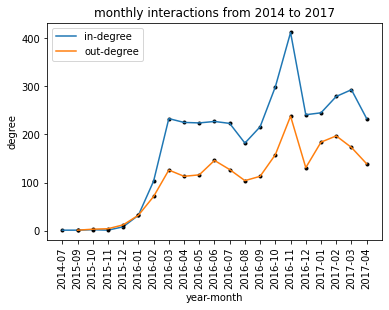

In [14]:
# edges coming out from the_donald
mask_donald_out = reddit_hyperlinks_positive.iloc[:, 0]=='the_donald' # 'the_donald' as source node
# edges entering the_donald
mask_donald_in = reddit_hyperlinks_positive.iloc[:, 1]=='the_donald' # 'the_donald' as target node
# plot evolution over the years
subreddits_interactions_over_years(mask_donald_in, mask_donald_out)

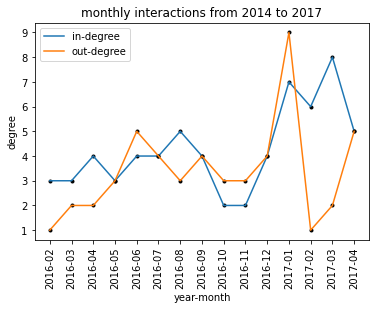

In [15]:
# edges the_donald -> conspiracy
mask_donald_out = np.logical_and(reddit_hyperlinks_positive.iloc[:, 0]=='the_donald', reddit_hyperlinks_positive.iloc[:, 1]=='conspiracy')
# edges conspiracy -> the_donald
mask_donald_in = np.logical_and(reddit_hyperlinks_positive.iloc[:, 1]=='the_donald', reddit_hyperlinks_positive.iloc[:, 0]=='conspiracy')
# plot evolution over the years
subreddits_interactions_over_years(mask_donald_in, mask_donald_out)

## Filter the data to create the network

In [16]:
# custom function to filter by years
def check_date(x, date):
  return date == x.split()[0].split('-')[0] # x = 'year-month-day hours-minute-seconds'

# filter the data. For computational reasons we'll just work on network data from 2016-2017
mask = reddit_hyperlinks_positive.iloc[:, 3].map(lambda x: (check_date(x, '2016') or check_date(x, '2017')))
reddit_hyperlinks_positive = reddit_hyperlinks_positive[mask]
reddit_hyperlinks_positive

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
984,movielists,movies,1usizvs,2016-01-19 01:22:55,1,"14839.0,13680.0,0.545724105398,0.154794797493,..."
3776,dogemarket_mi,dogemarket,1wdljbs,2016-03-22 09:34:53,1,"640.0,554.0,0.725,0.0265625,0.071875,0.165625,..."
4232,highdadjokes,stonerprotips,1wlqkrs,2017-04-19 00:15:44,1,"159.0,149.0,0.748427672956,0.0377358490566,0.0..."
16949,formerneckbeards,justneckbeardthings,23asets,2016-09-20 10:53:10,1,"1609.0,1416.0,0.754505904288,0.0118085767557,0..."
25709,shanghaigaybros,gaybros,27je0us,2016-07-22 00:25:57,1,"250.0,221.0,0.772,0.016,0.048,0.136,0.076,40.0..."
...,...,...,...,...,...,...
571920,peoplewhosayheck,dfsports,68iouss,2017-04-30 16:36:07,1,"123.0,106.0,0.780487804878,0.0,0.0813008130081..."
571921,brasilonreddit,roadcam,68ipe8s,2017-04-30 16:47:50,1,"71.0,63.0,0.788732394366,0.0,0.112676056338,0...."
571923,peoplewhosayheck,spiderman,68iqh6s,2017-04-30 16:36:07,1,"121.0,105.0,0.719008264463,0.0165289256198,0.0..."
571924,vzla,wtf,68iqkcs,2017-04-30 15:50:07,1,"68.0,58.0,0.764705882353,0.0,0.147058823529,0...."


In [17]:
# let's check if there is any dataset related to former POTUS Donald Trump

# set of all subreddits appearing in the dataset
subreddits = set(np.unique(reddit_hyperlinks_positive['SOURCE_SUBREDDIT'])) | set(np.unique(reddit_hyperlinks_positive['TARGET_SUBREDDIT']))

# let's find Trump-related subreddits 
trump_subreddits = []
for subreddit in subreddits:
  if 'trump' in subreddit.lower() or 'donald' in subreddit.lower():
    trump_subreddits.append(subreddit)

for s in trump_subreddits:
  print(s)

votetrumpyouloser
womenfortrump
trump_memes
trumpbehavingwell
impeach_trump
trumpregret
downwiththedonald
trump16
repost_the_donald
the_donald_2016
disrupttrump
trumpintelligence
trumpistan
the_donald_dissenters
donaldvshillary
trumpcalifornia
pure_trump
whatdidtrumpdonow
trumppolicy
trump_maga
better_donald
donaldglover
regrettingtrump
watchtrumpettescry
studsfortrump
antitrumpalliance
the_donald_lol
trumpgold
whatwouldtrumpsay
explainlikedonald
debatethedonald
replytothe_donald
normmacdonald
askthe_donald
letstalktrump
trump_god
elidonald
trumputah
mcdonalds
trumpgret
unexpectedtrump
entrumpreneurs
the_donald_2
trumppennsylvania
tinyhandstrump
trumpinvestigation
donaldtrump2016
trumptreason
trump_jokes
fuckedbytrump
the_donald_meta
donaldisfuckinglit
trumpmichigan
whataboutthedonald
sanders2trump
the_donald_texas
correctthedonald
trumplivesmatter
the_donaldbookclub
thee_donald
liestrumptoldus
anti_trump
trumpminnesota
trump4hillary
thedonaldgifs
trumpgate
trumpconnecticut
whyvoteford

In [18]:
# create the dataframe from which we'll define the network
reddit_hyperlinks_positive = reddit_hyperlinks_positive.iloc[:, [0, 1]] # [SOURCE, TARGET]

# to define the weight of the network we need to count the hyperlinks between a given source and a given target
# so let's group by wrt [SOURCE, TARGET]
reddit_hyperlinks_positive = reddit_hyperlinks_positive.value_counts(subset=['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT'])

In [19]:
reddit_hyperlinks_positive

SOURCE_SUBREDDIT      TARGET_SUBREDDIT
trendingsubreddits    changelog           215
moronicmondayandroid  android             209
longhornnation        cfb                 165
cig_rca               starcitizen         151
fireemblemcasual      fireemblem          148
                                         ... 
gunpolitics           news                  1
                      rant                  1
gunporn               foodforthought        1
                      glocks                1
zzseries              toontown              1
Length: 172708, dtype: int64

The previous dataset allows us to construct a directed network of interaction between subreddits. However, unfortunately, such a directed network is computationally more challenging to analyze.\
For this reason, we decided to transform the directed network into an undirected network.\
The new weight $\mathrm{w_u(A, B)}$ of the undirected connection between two subreddits $A$, $B$ will be given by the minimum between the weights $\mathrm{~ w_d(A, B)}$ and $\mathrm{w_d(B, A)}$ of the respective directed connections.\
That is:

\begin{align}
\mathrm{w_u(A, B)} = \min\{\mathrm{w_d(A, B)}, ~ \mathrm{w_d(B, A)}\}
\end{align} 

In [20]:
# define the network as an edge-list
tuples = []
for tpl in reddit_hyperlinks_positive.index: # tpl = [SOURCE, TARGET]
  if (tpl[1], tpl[0]) in reddit_hyperlinks_positive.index: # if [TARGET, SOURCE] exists
    # define the weight as the minimum between the directed weights
    weight = min(reddit_hyperlinks_positive[tpl], reddit_hyperlinks_positive[(tpl[1], tpl[0])])
    tuples.append((tpl[0], tpl[1], weight))

In [21]:
# Dataframe associated to the Undirected Weighted Network
network_df = pd.DataFrame(tuples, columns =['Source', 'Target', 'Weight'])
network_df

,Source,Target,Weight
0,longhornnation,cfb,2
1,fireemblemcasual,fireemblem,2
2,toronto,torontoevents,1
3,streetfighter,sf4,2
4,babymetal,sakuragakuin,11
...,...,...,...
26353,guns,bestof,1
26354,guns,1911,1
26355,guns,canadaguns,1
26356,guns,1911fans,1


In [22]:
# save the dataframe on google drive to access it later
network_df.to_csv(path_or_buf='/content/drive/MyDrive/Network_Science/reddit_network_undirected.csv', index=False)

In [23]:
# let's define the edges' weights will use across the different algorithms
edges_weight_list = tuple([(network_df.iloc[i, 0], network_df.iloc[i, 1], network_df.iloc[i, 2]) for i in network_df.index])
# inverse weights
edges_weight_list_reverse = tuple([(edge[0], edge[1], 1/edge[2]) for edge in edges_weight_list if edge[2]!=0])

# we can finally build the undirected network
g = nx.from_pandas_edgelist(network_df, source='Source', target='Target', edge_attr = 'Weight')

# Graph statistics

In [24]:
# number of nodes and edges
print('number of nodes: ', g.number_of_nodes())
print('number of edges: ', g.number_of_edges())
print('number of self-loops: ', nx.number_of_selfloops(g))

# connectivity
print('is the graph connected? ', nx.is_connected(g))

# number of connected components
print('number of Connected Components in the graph:', nx.number_connected_components(g))

# get the largest connected component in the graph
largest_cc = max(nx.connected_components(g), key=len)
largest_cc = g.subgraph(largest_cc)

# number of nodes and edges in the largest connected component
print('size of the largest Connected Component: ', largest_cc.number_of_nodes())
print('density of the largest Connected Component: ', largest_cc.number_of_edges())

# diameter of largest connected component
#print('diameter of largest Connected Component:', nx.diameter(largest_cc))

number of nodes:  7969
number of edges:  13179
number of self-loops:  0
is the graph connected?  False
number of Connected Components in the graph: 511
size of the largest Connected Component:  6666
density of the largest Connected Component:  12355


In [25]:
# check connected components size distribution
components_sizes = [(g.subgraph(c).copy()).number_of_nodes() for c in nx.connected_components(g)] # sized of the connected components
sizes, counts = np.unique(components_sizes, return_counts=True) # count size and related frequency
sizes = zip(list(sizes), list(counts))
list(sizes)

[(2, 404),
 (3, 58),
 (4, 24),
 (5, 7),
 (6, 7),
 (7, 2),
 (8, 2),
 (9, 3),
 (10, 1),
 (19, 1),
 (62, 1),
 (6666, 1)]

In [26]:
# for simplicity we'll work on the largest component,
# since it covers almost the whole graph
g = largest_cc

# list of nodes and associated degrees [(node, degree), ...]
nodes_degrees = [(item[0], item[1]) for item in dict(g.degree()).items()]
# list of nodes
nodes = [tpl[0] for tpl in nodes_degrees]
# list of degrees
degrees = [tpl[1] for tpl in nodes_degrees]

# percentage of nodes of degree 1
counts = 0
for i in range(len(degrees)):
  if degrees[i]==1: counts+=1
counts/=len(nodes)
print(counts)

# nodes with highest degree
sorted(nodes_degrees, key= lambda x: -x[1])

0.5418541854185418


[('the_donald', 299),
 ('conspiracy', 174),
 ('gaming', 166),
 ('subredditdrama', 154),
 ('sandersforpresident', 118),
 ('iama', 117),
 ('leagueoflegends', 115),
 ('bestof', 98),
 ('funny', 92),
 ('todayilearned', 79),
 ('games', 79),
 ('pcmasterrace', 78),
 ('android', 75),
 ('politics', 74),
 ('drama', 73),
 ('soccer', 72),
 ('videos', 72),
 ('overwatch', 69),
 ('pokemongo', 69),
 ('anime', 69),
 ('india', 68),
 ('enoughtrumpspam', 67),
 ('political_revolution', 63),
 ('techsupport', 62),
 ('bitcoin', 62),
 ('de', 62),
 ('legaladvice', 62),
 ('movies', 59),
 ('nba', 55),
 ('globaloffensive', 55),
 ('buildapc', 54),
 ('sysadmin', 54),
 ('pokemon', 54),
 ('anarcho_capitalism', 52),
 ('nfl', 52),
 ('anarchism', 52),
 ('dota2', 51),
 ('baseball', 50),
 ('hockey', 50),
 ('oculus', 50),
 ('news', 50),
 ('newsokur', 49),
 ('canada', 48),
 ('socialism', 47),
 ('pcgaming', 47),
 ('outoftheloop', 46),
 ('elitedangerous', 46),
 ('cringeanarchy', 46),
 ('trees', 46),
 ('ethereum', 45),
 ('agains

# Degree Distribution

In [24]:
# get degrees and related frequencies
degree_seq, degree_probs = np.unique(degrees, return_counts=True)
degree_probs = degree_probs/np.sum(degree_probs)
# define the CDF of the degree
degree_CDF = np.cumsum(degree_probs)

# define the dictionary in which for each degree we'll save [degree, frequency, CCDF(degree)]
degree_distr = {}
for i in range(len(degree_seq)):
  degree_distr[i] = [degree_seq[i], degree_probs[i], 1-degree_CDF[i]]

# convert dictionary to dataframe 
degree_distr = pd.DataFrame.from_dict(degree_distr, orient='index')

# sort the dataframe in increasing order w.r.t. degree
degree_distr  = degree_distr.sort_values([0], ascending = [True])

In [25]:
# In the following we estimate the power exponent of the distribution
# the plots from which we deduced the the degree distribution is indeed a power-law are reported below

data = np.array(degree_distr)
kmin = 2 #np.min(data[:, 0])
mask = data[:,0]>=kmin

# estimating gamma via maximum likelihood
gamma_MLE = 1 + len(nodes)/np.sum(np.log(degree_distr.iloc[:, 0]/kmin))

# line that best fits the degree distribution in log-log scale:
reg = LinearRegression().fit(np.log(data[mask, 0].reshape(-1, 1)), np.log(data[mask, 1]))
degree_distr_line = reg.predict(np.log(data[:, 0]).reshape(-1, 1))
gamma_loglog_distr = -float(reg.coef_)

# line that best fits the degree CCDF in log-log scale:
mask2 = data[:, 2] > 0
reg = LinearRegression().fit(np.log(data[np.logical_and(mask, mask2), 0].reshape(-1, 1)), np.log(data[np.logical_and(mask, mask2), 2]))
degree_CCDF_line = reg.predict(np.log(data[:, 0]).reshape(-1, 1))
gamma_CCDF = -float(reg.coef_)

print(gamma_CCDF)

2.5209417809405896


In [26]:
# compute some network statistics, both theoretically and empirically

# natural cut-off
kmax_theoretical = kmin*np.power(len(nodes)+1, 1/(gamma_CCDF-1))
kmax_empirical = np.max(degree_seq)

# normalizing constant
C_theoretical = (1-gamma_CCDF)/(np.power(kmax_theoretical, 1-gamma_CCDF)-np.power(kmin, 1-gamma_CCDF))
C_empirical = 1/np.sum(np.power(degree_distr.iloc[:,0], -gamma_CCDF))

# first moment <k>
k1_theoretical = C_theoretical*(np.power(kmax_theoretical, 2-gamma_CCDF)-np.power(kmin, 2-gamma_CCDF))/(2-gamma_CCDF)
k1_empirical = np.sum(degree_distr.iloc[:,0]*degree_distr.iloc[:,1])

# second moment <k^2>
k2_theoretical = C_theoretical*(np.power(kmax_theoretical, 3-gamma_CCDF)-np.power(kmin, 3-gamma_CCDF))/(3-gamma_CCDF)
k2_empirical = np.sum(degree_distr.iloc[:,0]*degree_distr.iloc[:,0]*degree_distr.iloc[:,1])

# inhomogeneity ratio (for robustness analysis)
k_theoretical = k2_theoretical/k1_theoretical
k_empirical = k2_empirical/k1_empirical

print('kmin = ', kmin)
print('theoretical kmax = ', kmax_theoretical)
print('empirical kmax = ', kmax_empirical)

print('theoretical C = ', C_theoretical)
print('empirical C = ', C_empirical)

print('theoretical <K> = ', k1_theoretical)
print('empirical <K> = ', k1_empirical)

print('theoretical <K^2> = ', k2_theoretical)
print('empirical <K^2> = ', k2_empirical)

print('theoretical k = ', k_theoretical)
print('empirical k = ', k_empirical)

print('gamma_loglog_distr = ', gamma_loglog_distr)
print('gamma_CCDF = ', gamma_CCDF)
print('gamma_MLE = ', gamma_MLE)

kmin =  2
theoretical kmax =  653.4553903699951
empirical kmax =  299
theoretical C =  4.365428041657183
empirical C =  0.7505701281603445
theoretical <K> =  5.553873668071217
empirical <K> =  3.706870687068707
theoretical <K^2> =  190.67052995135154
empirical <K^2> =  93.2058205820582
theoretical k =  34.331088776379886
empirical k =  25.144071226224195
gamma_loglog_distr =  1.6696361219664209
gamma_CCDF =  2.5209417809405896
gamma_MLE =  33.09667718235373


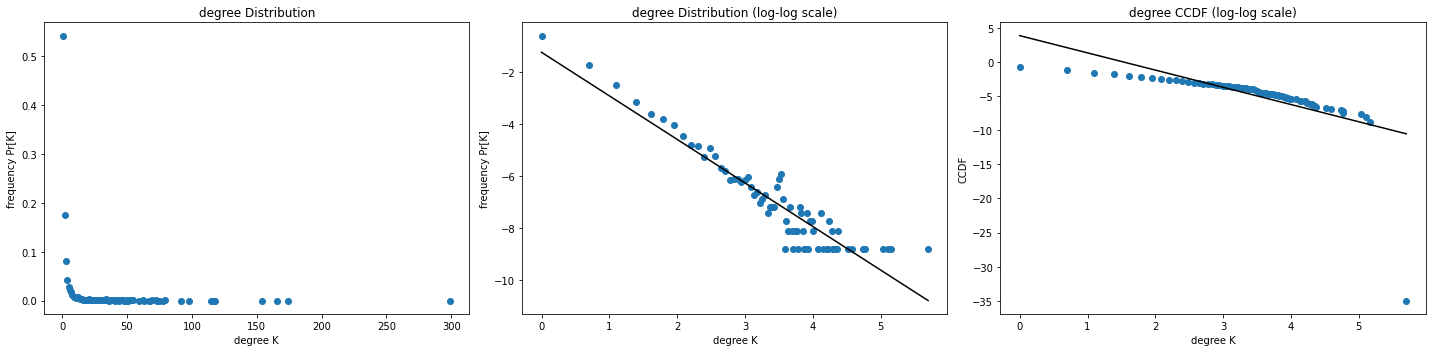

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].scatter(degree_distr.iloc[:, 0], degree_distr.iloc[:, 1])
axs[0].set_xlabel('degree K')
axs[0].set_ylabel('frequency Pr[K]')
axs[0].set_title('degree Distribution')

axs[1].scatter(np.log(degree_distr.iloc[:, 0]), np.log(degree_distr.iloc[:, 1]))
axs[1].set_xlabel('degree K')
axs[1].set_ylabel('frequency Pr[K]')
axs[1].set_title('degree Distribution (log-log scale)')
axs[1].plot(np.log(degree_distr.iloc[:, 0]), degree_distr_line, c='k')

axs[2].scatter(np.log(degree_distr.iloc[:, 0]), np.log(degree_distr.iloc[:, 2]))
axs[2].set_xlabel('degree K')
axs[2].set_ylabel('CCDF')
axs[2].set_title('degree CCDF (log-log scale)')
axs[2].plot(np.log(degree_distr.iloc[:, 0]), degree_CCDF_line, c='k')

plt.subplots_adjust(wspace=0.5)
fig.tight_layout()
plt.show()

# Clustering Coefficients

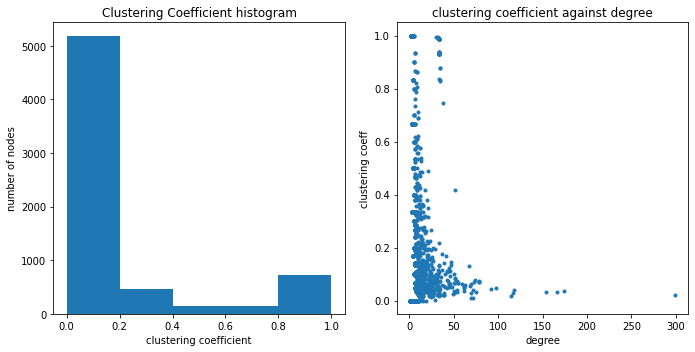

In [28]:
# let's also compute the Clustering Coefficients to examine the local density of each node's neighborhood
clustering_coeffs = nx.clustering(g)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# clustering coefficients distribution
axs[0].hist(clustering_coeffs.values(), bins=5)
axs[0].set_xlabel('clustering coefficient')
axs[0].set_ylabel('number of nodes')
axs[0].set_title('Clustering Coefficient histogram')

# clustering coefficients against degree distribution
axs[1].scatter(dict(nx.degree(g)).values(), clustering_coeffs.values(), marker='.')
axs[1].set_xlabel('degree')
axs[1].set_ylabel('clustering coeff')
axs[1].set_title('clustering coefficient against degree')

plt.subplots_adjust(wspace=1)
fig.tight_layout()
plt.show()

In [29]:
# let's also compute the Global Average Clustering Coefficient of the graph
# this will give us an idea of how dense the network is locally
global_avg_cls_coeff = np.mean(list(clustering_coeffs.values()))
print('global average clustering coeff: ', global_avg_cls_coeff)

# number of nodes with Clustering Coeff = 1
counts=0
for cc in list(clustering_coeffs.values()):
  if cc==1: counts+=1
counts/=len(nodes)
print(counts)

global average clustering coeff:  0.16396767421734856
0.09795979597959796


In [30]:
# nodes with highest clustering coefficients
sorted(list(clustering_coeffs.items()), key=lambda x: -x[1])

[('fireemblemcasual', 1.0),
 ('brasil_drama', 1.0),
 ('gaybroscirclejerk', 1.0),
 ('ps4planetside2', 1.0),
 ('nbacirclejerk', 1.0),
 ('gender_critical', 1.0),
 ('njpw', 1.0),
 ('cloud9', 1.0),
 ('brasilivre', 1.0),
 ('indiewrestling', 1.0),
 ('roh', 1.0),
 ('syriancirclejerkwar', 1.0),
 ('diy_classifieds', 1.0),
 ('rengarmains', 1.0),
 ('greatxboxdeals', 1.0),
 ('hxh_oc', 1.0),
 ('superherocirclejerk', 1.0),
 ('rivenmains', 1.0),
 ('truedota2', 1.0),
 ('phonesexwithtodd', 1.0),
 ('bitcoin_uncensored', 1.0),
 ('magicthecirclejerking', 1.0),
 ('gwascriptguild', 1.0),
 ('ketorecipes', 1.0),
 ('legaladviceofftopic', 1.0),
 ('gcdebatesqt', 1.0),
 ('pureasoiaf', 1.0),
 ('truetf2', 1.0),
 ('falloutsettlements', 1.0),
 ('plaza_podemos', 1.0),
 ('tv_ja', 1.0),
 ('torontomarlies', 1.0),
 ('allthingsterran', 1.0),
 ('canonn', 1.0),
 ('homelabsales', 1.0),
 ('teamredditteams', 1.0),
 ('behindthetables', 1.0),
 ('cuddle_with_me', 1.0),
 ('eltp', 1.0),
 ('daodil', 1.0),
 ('sffpc', 1.0),
 ('flyers', 

# Assortativity 

In [31]:
# degree assortativity via Pearson coefficient
r = nx.degree_assortativity_coefficient(g, weight='Weight')
print('network degree assortativity coefficient r = ', r)

network degree assortativity coefficient r =  -0.035977483432706424


In [32]:
# we now study assortativity using the Knn function (Average Neighbour Degree)

# to compute Knn without using weights
# degrees = nx.degree(g)

# compute weighted degrees using the Adjacency matrix
degrees={}
A = nx.adjacency_matrix(g, weight='Weight').toarray()
for i in range(len(nodes)):
  degrees[nodes[i]] = np.sum(A[i, :])

# compute average degree of neighbors function (Knn)
avg_neigh_degrees = nx.average_neighbor_degree(g, weight='Weight')

# recompute Knn after 100 random rewiring and take the mean
# initialize the dictionaty which will store the values
avg_neigh_degrees_rewired = {}
for node in nodes:
  avg_neigh_degrees_rewired[node] = 0

# recompute Knn after 100 random rewiring and take the mean
for i in range(100):
  # random rewiring
  rewired_graph = nx.random_reference(g, niter=1, connectivity=False)
  # compute Knn
  knn_rewired = nx.average_neighbor_degree(rewired_graph, weight='Weight')
  # save the results. Recall that we want to take the mean
  for node in nodes:
    avg_neigh_degrees_rewired[node] += knn_rewired[node]/100

In [33]:
# let's now compare the distributions of Knn before and after random rewiring
knn = {}
for node in nodes:
  knn[node] = [degrees[node], avg_neigh_degrees[node], avg_neigh_degrees_rewired[node]]

# convert dictionary to dataframe 
knn = pd.DataFrame.from_dict(knn, orient='index')

# sort the dataframe in increasing order w.r.t. degree
knn = knn.sort_values([0], ascending = [True])
print(knn)

                       0           1          2
gtavip                 1   11.000000  18.520000
elsanna                1    2.000000  29.700000
shadowofmordor         1  166.000000  52.910000
ftmfitness             1    4.000000  24.440000
plazacatalunya         1    6.000000  31.010000
...                  ...         ...        ...
gaming               381   32.530184  23.691564
nfl                  407   34.945946  28.918157
sandersforpresident  421   36.358670  27.948170
conspiracy           515   53.186408  35.707396
the_donald           939   36.900958  26.206934

[6666 rows x 3 columns]


In [34]:
# let's now compute the mean value of Knn and Knn_after_rewiring for each degree
knn_means = {}
for degree in np.unique(np.array(list(dict(degrees).values()))): # set of all degrees
  # in the first entry save the mean of Knn
  # in the second entry save the mean of Knn after random rewiring
  knn_means[degree]=[0, 0] 
  # find the set of node with given degree
  nodes_with_fixed_degree = list(knn[knn.loc[:, 0]==degree].index)
  # save the results
  for node in nodes_with_fixed_degree:
    knn_means[degree][0]+=knn.loc[node,1]/len(nodes_with_fixed_degree) # mean of Knn for a fixed degree
    knn_means[degree][1]+=knn.loc[node,2]/len(nodes_with_fixed_degree) # mean of Knn_after_rewiring for a fixed degree

# convert dictionary to dataframe 
knn_means = pd.DataFrame.from_dict(knn_means, orient='index')
knn_means = knn_means.reset_index(level=0)
print(knn_means)

     index          0          1
0        1  27.127755  26.732880
1        2  25.384335  26.212450
2        3  29.420410  27.278935
3        4  31.043505  27.262569
4        5  28.205283  26.838730
..     ...        ...        ...
150    381  32.530184  23.691564
151    407  34.945946  28.918157
152    421  36.358670  27.948170
153    515  53.186408  35.707396
154    939  36.900958  26.206934

[155 rows x 3 columns]


In [35]:
# we now fit the Knn_means distributions via Ordinary Least Squares (in log-log scale)

data = np.array(knn_means)

# line that best fits the knn_means distribution:
reg = LinearRegression().fit(np.log(data[:, 0].reshape(-1, 1)), np.log(data[:, 1]))
knn_line = reg.predict(np.log(data[:, 0]).reshape(-1, 1))

# line that best fits the knn_means_after_rewiring distribution:
reg = LinearRegression().fit(np.log(data[:, 0].reshape(-1, 1)), np.log(data[:, 2]))
knn_rewired_line = reg.predict(np.log(data[:, 0]).reshape(-1, 1))

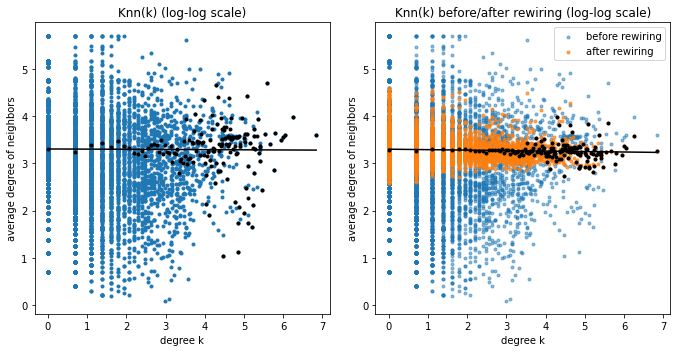

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(np.log(knn.iloc[:, 0]), np.log(knn.iloc[:, 1]), marker='.')
ax1.scatter(np.log(knn_means.iloc[:, 0]), np.log(knn_means.iloc[:, 1]), marker='.', c='k')
ax1.plot(np.log(knn_means.iloc[:, 0]), knn_line, c='k')
ax1.set_xlabel('degree k')
ax1.set_ylabel('average degree of neighbors')
ax1.set_title('Knn(k) (log-log scale)')

ax2.scatter(np.log(knn.iloc[:, 0]), np.log(knn.iloc[:, 1]), alpha=0.5, label='before rewiring', marker='.')
ax2.scatter(np.log(knn.iloc[:, 0]), np.log(knn.iloc[:, 2]), alpha=0.7, label='after rewiring', marker='.')
ax2.scatter(np.log(knn_means.iloc[:, 0]), np.log(knn_means.iloc[:, 2]), marker='.', c='k')
ax2.plot(np.log(knn_means.iloc[:, 0]), knn_rewired_line, c='k')
ax2.set_xlabel('degree k')
ax2.set_ylabel('average degree of neighbors')
ax2.set_title('Knn(k) before/after rewiring (log-log scale)')
ax2.legend()

plt.subplots_adjust(wspace=1)
fig.tight_layout()
plt.show()

# Centrality measures

## HITS centrality

In [37]:
# compute HITS centrality
hub_centrality, authority_centrality = nx.hits(g)

In [38]:
# 100 highest hub-ranked nodes
for item in sorted(hub_centrality.items(), key=lambda x:x[1], reverse=True)[:100]:
  print(item)

('nfl', 0.0245405848995055)
('panthers', 0.02392988022117781)
('detroitlions', 0.02386354002601495)
('nygiants', 0.02386354002601495)
('nyjets', 0.02386354002601495)
('denverbroncos', 0.023842148352536344)
('bengals', 0.023842148352536344)
('chargers', 0.023823609604165585)
('redskins', 0.023820469751295783)
('chibears', 0.023786691072724176)
('greenbaypackers', 0.023781174661561932)
('seahawks', 0.023781162876160833)
('browns', 0.023778057236626286)
('falcons', 0.023777003984899053)
('steelers', 0.023776742028424083)
('oaklandraiders', 0.023776698069163486)
('buccaneers', 0.02375519719520351)
('miamidolphins', 0.02375519719520351)
('saints', 0.02375519719520351)
('ravens', 0.02375519719520351)
('49ers', 0.02375519719520351)
('jaguars', 0.02375519719520351)
('azcardinals', 0.02375519719520351)
('kansascitychiefs', 0.02375519719520351)
('colts', 0.02375519719520351)
('texans', 0.023223715676797936)
('nfl_draft', 0.02317440873104777)
('cowboys', 0.023132941951601822)
('losangelesrams', 0

In [39]:
# 100 highest authority-ranked nodes
for item in sorted(authority_centrality.items(), key=lambda x:x[1], reverse=True)[:100]:
  print(item)

('nfl', 0.02454058489950549)
('panthers', 0.023929880221177795)
('detroitlions', 0.023863540026014936)
('nyjets', 0.023863540026014936)
('nygiants', 0.023863540026014932)
('denverbroncos', 0.02384214835253634)
('bengals', 0.02384214835253633)
('chargers', 0.023823609604165578)
('redskins', 0.023820469751295766)
('chibears', 0.02378669107272417)
('greenbaypackers', 0.023781174661561932)
('seahawks', 0.02378116287616083)
('browns', 0.023778057236626272)
('falcons', 0.023777003984899046)
('steelers', 0.023776742028424076)
('oaklandraiders', 0.02377669806916347)
('jaguars', 0.023755197195203505)
('kansascitychiefs', 0.023755197195203505)
('miamidolphins', 0.0237551971952035)
('ravens', 0.0237551971952035)
('colts', 0.0237551971952035)
('buccaneers', 0.023755197195203498)
('saints', 0.023755197195203498)
('49ers', 0.023755197195203498)
('azcardinals', 0.023755197195203494)
('texans', 0.023223715676797926)
('nfl_draft', 0.02317440873104777)
('cowboys', 0.023132941951601822)
('losangelesrams'

## Pagerank centrality

In [40]:
# compute Pagerank centrality scores
pagerank_centrality = nx.pagerank(g, weight='Weight')

In [41]:
# 100 highest ranked nodes
for item in sorted(pagerank_centrality.items(), key=lambda x:x[1], reverse=True)[:100]:
  print(item)

('the_donald', 0.012508857732872337)
('conspiracy', 0.0065710605597998845)
('gaming', 0.005742365976891755)
('leagueoflegends', 0.005702171689658454)
('sandersforpresident', 0.005687711827354218)
('subredditdrama', 0.004568771516600397)
('iama', 0.004235519673079608)
('soccer', 0.003923326975622796)
('overwatch', 0.003626287341409491)
('android', 0.0035632366367806495)
('politics', 0.003479622262272229)
('anime', 0.003428641113387477)
('pokemongo', 0.0033306144076168187)
('drama', 0.0028111746214136792)
('techsupport', 0.002708729646317866)
('funny', 0.0026941639043732927)
('baseball', 0.0026803173180229905)
('newsokur', 0.0026691610001403385)
('political_revolution', 0.002662764858698444)
('bitcoin', 0.0026597236047735642)
('buildapc', 0.002622074028015832)
('sysadmin', 0.0026190296615401505)
('dota2', 0.002592635738820211)
('movies', 0.0025188158845387753)
('ethereum', 0.0024539186145883848)
('thesilphroad', 0.0024414380446093394)
('hockey', 0.0024403422568686074)
('btc', 0.002430426

### Comparison (degree, HITS, Pagerank)

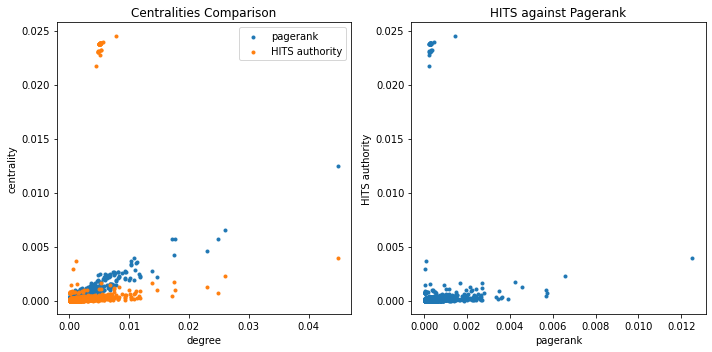

In [42]:
# compute degree centrality for comparison
degree_centrality = nx.degree_centrality(g)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(degree_centrality.values(), pagerank_centrality.values(), label='pagerank', marker='.')
axs[0].scatter(degree_centrality.values(), authority_centrality.values(), label='HITS authority', marker='.')
axs[0].set_xlabel('degree')
axs[0].set_ylabel('centrality')
axs[0].set_title('Centralities Comparison')
axs[0].legend()

axs[1].scatter(pagerank_centrality.values(), authority_centrality.values(), marker='.')
axs[1].set_xlabel('pagerank')
axs[1].set_ylabel('HITS authority')
axs[1].set_title('HITS against Pagerank')

plt.subplots_adjust(wspace=1.5)
fig.tight_layout()
plt.show()

# Community Detection

## Louvain Modularity Maximization

In [195]:
# compute Louvain communities
communities = nx_cd.louvain_communities(g, weight='Weight')

# compute modularity of the partitioning
modularity = nx_cd.modularity(g, communities=communities, weight='Weight')

# size of largest community
M=0
for community in communities:
  l = len(community)
  if l>=M:
    M=l

print('modularity: ', modularity, '\nnumber of communities: ', len(communities), '\nsize of largest community: ', M)

modularity:  0.8380270643771057 
number of communities:  59 
size of largest community:  877


In [44]:
# build up the dictionary {node : community index}
louvain_communities = {}
for i in range(len(communities)):
  for node in communities[i]:
    louvain_communities[node] = i

## Consensus Clustering via Louvain Modularity maximization

In [45]:
# apply Consensus Clustering using Louvain Community Detection algorithm

# parameters needed for Consensus Clustering algorithm
toll = 10^(-2)
max_iter = 2 # max number of iterations
num_iter_louvain = 5 # number of time we apply Louvain at each iteration
consensus_matrix = nx.adjacency_matrix(g, weight='Weight').toarray() # adjacency matrix of the network
D = consensus_matrix + np.eye(len(nodes)) # we sum the identity just to enter the following while loop

In [46]:
iter = 0

while la.norm(consensus_matrix - D, ord='fro')>=toll and iter<=max_iter:

  iter += 1

  print(iter)

  communities = {} # here we'll store the communities found at each application of Louvain
  D = consensus_matrix  
  # initialize consensus matrix as the all-zero matrix
  consensus_matrix = np.zeros((len(nodes), len(nodes)))

  # create the network from the consensus matrix. Recall that at first iteration D = Adjacency matrix of the graph 
  network_df_louvain = pd.DataFrame(D, index=nodes, columns=nodes)  
  graph = nx.from_pandas_adjacency(network_df_louvain)

  # repeatedly apply Louvain
  for i in range(num_iter_louvain):
    # save the partitioning
    communities[i] = nx_cd.louvain_communities(graph, weight='Weight')    

  # now we build the consensus matrix D
  # for each pair of nodes we need to count the fraction of times they appear in the same community
  for k in range(num_iter_louvain):
    for community in communities[k]: # for each partitioning
      community = list(community) # for each community in each partitioning
      for i in range(len(community)): # for each pair of nodes in the community update the consensus matrix
        for j in range(i+1, len(community)):
          consensus_matrix[nodes.index(community[i]), nodes.index(community[j])] = 1
          consensus_matrix[nodes.index(community[j]), nodes.index(community[i])] = 1
  consensus_matrix = consensus_matrix/num_iter_louvain # take the frequency

1
2
3


In [47]:
# create graph from the final consenssu matrix
network_df_louvain = pd.DataFrame(consensus_matrix, index=nodes, columns=nodes)  
graph = nx.from_pandas_adjacency(network_df_louvain)

# finally reapply Louvain one last time
communities = nx_cd.louvain_communities(graph, weight='Weight')

# create the dictionary {node : community index}
consensus_clustering = {}
for i in range(len(communities)):
  for node in communities[i]:
    consensus_clustering[node] = i

consensus_clustering

{'ethtradeclub': 0,
 'firewoodvapes': 0,
 'silphroadnortheast': 0,
 'mawinstallation': 0,
 'ethermining': 0,
 'actionfigures': 0,
 'rhockeymockdraft': 0,
 'civaigames': 0,
 'pokemongogta': 0,
 'mltp': 0,
 'melbournesocialclub': 0,
 'vaporents': 0,
 'phillies': 0,
 'nhl_games': 0,
 'idgod': 0,
 'metta': 0,
 'houseplants': 0,
 'everton': 0,
 'funnyanimals': 0,
 'atletico': 0,
 'nhlstreams': 0,
 'eubazaar': 0,
 'mrrobotlounge': 0,
 'eldertrees': 0,
 'kungfu': 0,
 'fakemon': 0,
 'dwarffortress': 0,
 'muricanized': 0,
 'jeopardy': 0,
 'musictheory': 0,
 'collapsesupport': 0,
 'zen': 0,
 'portabledabs': 0,
 'music': 0,
 'afcon': 0,
 'archaicrevival': 0,
 'meditation': 0,
 'wwe_network': 0,
 'ootp': 0,
 'basspedals': 0,
 'aftertheendckii': 0,
 'nftl': 0,
 'reasoners': 0,
 'boundlessvapes': 0,
 'tppleague': 0,
 'megumin': 0,
 'backpacks': 0,
 'canadian_ecigarette': 0,
 'autoflowers': 0,
 'officialafs': 0,
 'pokemonuranium': 0,
 'steelbooks': 0,
 'teamvalor': 0,
 'moderncoins': 0,
 'warhammer':

In [48]:
# create the partitioning
partitions = [[node for node in consensus_clustering.keys() if consensus_clustering[node]==community_index] 
                for community_index in set(consensus_clustering.values())]

# compute modularity
modularity = nx_cd.modularity(g, communities=partitions, weight='Weight', resolution=1)

# size of largest community
M=0
for partition in partitions:
  l = len(partition)
  if l>=M:
    M=l

print('modularity: ', modularity, '\nnumber of communities: ', len(partitions), '\nsize of largest community: ', M)

modularity:  0.7417441726264452 
number of communities:  17 
size of largest community:  2103


In [49]:
# 'the_donald' community
[key for key in consensus_clustering.keys() if consensus_clustering[key]==consensus_clustering['the_donald']]

['imgoingtohellforthis',
 'spirituality',
 'shittheadminssay',
 'resannouncements',
 'mormonleaks',
 'walkercountyal',
 'fscomeau',
 'amifreetogo',
 'worldnews',
 'berniecrats',
 'debatecommunism',
 'southcarolina',
 'polycentric_law',
 'newaccountsinpolitics',
 'shitliberalssay',
 'spaceengine',
 'breakawayminyan',
 'sadcringe',
 'thisisnotagame',
 'brawlhalla',
 'femmethoughts',
 'famnnfp',
 'uncensored',
 'offmychest',
 'highstrangeness',
 'womenfortrump',
 'rightwinglgbt',
 'fortcollins',
 'leftwithoutedge',
 'yellowperil',
 'tempe',
 'copypasta',
 'pareidolia',
 'cincybiking',
 'anarchogaming',
 'purdue',
 'exmuslim',
 'endfptp',
 'im14andthisisdeep',
 'militaryporn',
 'korea',
 'badlegaladvice',
 'jokes',
 'exismailis',
 'socialismvcapitalism',
 'ohio',
 'socialskills',
 'the_europe',
 'therealjillstein',
 'placesnek',
 'pussypassdenied',
 'asklinguistics',
 'economics',
 'mensrants',
 'berniesanders',
 'anarchismonline',
 'prematurecelebration',
 'ieforsanders',
 'neverhillary',

In [50]:
consensus_clustering_df = pd.DataFrame.from_dict(consensus_clustering, orient='index')
# save the dataframe on google drive to access it later
consensus_clustering_df.to_csv(path_or_buf='/content/drive/MyDrive/Network_Science/consensus_clustering.csv')

## Authority Shifting using Personalized Pagerank

In [51]:
# Authority Shifting turned out to be computationally demanding.
# In the following you find two different implementations. This first one is more efficient and should be used

# The initial idea was to save the partitioning in a dictionary as {node : community index}
# However to compute modularity using networkx we need the partitioning to be a list of lists
# it turned out that building the list of lists from the dictionary is extremely slow and inefficient
# thus this second version was implemented

# The idea here is to save the partitioning using a boolean numpy matrix M
# if node vi and vj are in the same community then set M[i,j] = 1
# we initialize M as the identity, since at the beginning each node is its own community
# notice though that if we want to put vj in the same community as vi, updating just M[i, j] is not enough
# indeed, we need to update also the entries for every node in the community of vi, and every node in the community of vj

#-------------------------------------------------------------------------------

nodes_np = np.array(nodes) # convert nodes to numpy array for quicker and easier indexing using boolean masks

# initialize communities as singletons
# each node will be its own community
communities = np.eye(len(nodes))

# keep a copy to temporary merge communities based on pagerank
communities_copy = communities.copy()

# define partitioning in order to compute modularity (list of lists, quicker than using dictionaries)
partitions = [list(nodes_np[communities_copy[i, :]==1]) for i in range(len(nodes_np))]

# to favor larger communities we may consider the k highest ranked nodes wrt to local pagerank
# instead of considering just the highest ranked one. Similarly we may also choose different 
# resolution parameter for the modularity function. Higher resolutions favor smaller communities
k = 2
resolution = 1

# compute modularity of graph to assess whether merging communities is convenient 
modularity_old = nx_cd.modularity(g, communities=partitions, weight='Weight', resolution=resolution)

for i in range(len(nodes)):

  # compute local pagerank wrt to i-th node
  local_pagerank = nx.pagerank(g, weight='Weight', personalization={nodes[i] : 1})
  
  # take the k highest ranked nodes
  highest_ranked_nodes =  [item[0] for item in sorted(local_pagerank.items(), key = lambda x: x[1], reverse=True)[:k]]  
  # now take their indexes in the nodes list. We need these indexes to access the matrix 
  highest_ranked_nodes_indexes = []
  for high_ranked_node in highest_ranked_nodes:
    highest_ranked_nodes_indexes.append(nodes.index(high_ranked_node))  

  # merge the communities associated with i-th node and highest ranked nodes
  # it'll suffice to add up the related rows in the community_copy matrix
  for index in highest_ranked_nodes_indexes:
    for j in range(len(nodes)): #  update the entries for every node in the community of vi
      if communities_copy[i, j]>0:
        communities_copy[j, :] += communities_copy[index, :]
    for j in range(len(nodes)): # update the entries for every node in the community of the highest_ranked_nodes
      if communities_copy[index, j]>0:
        communities_copy[j, :] = communities_copy[i, :]    
  # use boolean masking to get back a binary matrix
  communities_copy = communities_copy > 0

  # compute the new partitioning 
  partitions = [tuple(nodes_np[communities_copy[i, :]==1]) for i in range(len(nodes_np))] # list of tuples
  # notice that this is not yet a partitioning since nodes in the same community will receive the same tuple
  # to get a partitioning we need to discard repeated tuples
  partitions = list(dict.fromkeys(partitions))  

  # compute new modularity
  modularity = nx_cd.modularity(g, communities=partitions, weight='Weight', resolution=resolution)

  print(i, '\t', nodes[i], '\t', highest_ranked_nodes, '\t\t', modularity>=modularity_old)

  # if modularity increases then keep the merged communities
  if modularity>=modularity_old:
    communities = communities_copy
    communities_copy = communities.copy()
    modularity_old = modularity

  # else undo the merging and go back to the previous set of communities
  else:
    communities_copy = communities.copy()



Output streaming troncato alle ultime 5000 righe.
1666 	 republicansforsanders 	 ['sandersforpresident', 'republicansforsanders'] 		 True
1667 	 findaleague 	 ['findaleague', 'fantasyfootball'] 		 True
1668 	 isro 	 ['isro', 'india'] 		 True
1669 	 reagenttesting 	 ['drugs', 'reagenttesting'] 		 True
1670 	 cosmere 	 ['cosmere', 'stormlight_archive'] 		 True
1671 	 stormlight_archive 	 ['stormlight_archive', 'fantasy'] 		 True
1672 	 redditcensorship 	 ['conspiracy', 'redditcensorship'] 		 True
1673 	 aeon 	 ['aeon', 'cryptocurrency'] 		 True
1674 	 hyderabad 	 ['india', 'hyderabad'] 		 True
1675 	 benzodiazepines 	 ['drugs', 'benzodiazepines'] 		 True
1676 	 deathstranding 	 ['neverbegameover', 'deathstranding'] 		 True
1677 	 wowguilds 	 ['wow', 'wowguilds'] 		 True
1678 	 dogemarket 	 ['dogecoin', 'dogemarket'] 		 True
1679 	 pmsfeedback 	 ['pmsforsale', 'silverbugs'] 		 True
1680 	 wowui 	 ['wow', 'wowui'] 		 True
1681 	 dogethereum 	 ['ethereum', 'dogethereum'] 		 True
1682 	 ftm 

In [52]:
###################################################
# ALTERNATIVE VERSION OF AUTHORITY SHIFTING
# (EASIER TO UNDERSTAND BUT WAY LESS EFFICIENT)
###################################################



# # initialize communities as singletons
# # each node will be its own community
# communities = {}
# for i in range(len(nodes)):
#   communities[nodes[i]] = i

# # keep a copy to temporary merge communities based on pagerank
# communities_copy = communities.copy()

# # define partitioning in order to compute modularity
# partitions = [[key] for key in communities_copy.keys()]

# # to favor larger communities we may consider the k highest ranked nodes wrt to local pagerank
# # instead of considering just the highest ranked one. Similarly we may also choose different 
# # resolution parameter for the modularity function. Higher resolutions favor smaller communities
# k = 2
# resolution = 1

# # compute modularity of graph to assess wheter merging communities is convenient 
# modularity_old = nx_cd.modularity(g, communities=partitions, weight='Weight', resolution=resolution)

# for i in range(len(nodes)):

#   # compute local pagerank wrt to i-th node
#   local_pagerank = nx.pagerank(g, weight='Weight', personalization={nodes[i] : 1})
  
#   # take the k highest ranked nodes
#   highest_ranked_nodes =  [item[0] for item in sorted(local_pagerank.items(), key = lambda x: x[1], reverse=True)[:k]]  

#   # merge the communities associated with i-th node and highest ranked nodes
#   # it'll suffice to change the int value associated with the key highest_ranked_nodes  
#   for high_ranked_node in highest_ranked_nodes:
#     for node in [node for node in nodes if communities_copy[node]==communities_copy[high_ranked_node]]:
#       communities_copy[node] = communities_copy[nodes[i]]

#   # compute the new partitioning 
#   partitions = [[node for node in communities_copy.keys() if communities_copy[node]==community_index] 
#                 for community_index in set(communities_copy.values())]

#   # compute new modularity
#   modularity = nx_cd.modularity(g, communities=partitions, weight='Weight', resolution=resolution)

#   print(i, '\t', nodes[i], '\t', highest_ranked_nodes, '\t\t', modularity>=modularity_old)

#   # if modularity increases then keep the merged communities
#   if modularity>=modularity_old:
#     communities = communities_copy
#     communities_copy = communities.copy()
#     modularity_old = modularity

#   # else undo the merging and go back to the previous set of communities
#   else:
#     communities_copy = communities.copy()



In [53]:
# build up the final set of communities
partitions = [tuple(nodes_np[communities[i, :]==1]) for i in range(len(nodes_np))]
partitions = list(dict.fromkeys(partitions))

# size of largest community
M=0
for partition in partitions:
  l = len(partition)
  if l>=M:
    M=l

print('modularity: ', modularity, '\nnumber of communities: ', len(partitions), '\nsize of largest community: ', M)

modularity:  0.7865429762148831 
number of communities:  422 
size of largest community:  840


In [54]:
# build up the final dictionary {node : community index} for node in nodes
pagerank_communities = {}
for i in range(len(partitions)):
  for node in partitions[i]:
    pagerank_communities[node] = i

In [55]:
# let's take a look at the community associated with the_donald
[key for key in pagerank_communities.keys() if pagerank_communities[key]==pagerank_communities['the_donald']]

['toronto',
 'torontoevents',
 'hailcorporate',
 'shitpost',
 'anarcho_capitalism',
 'shitshitpost',
 'islam',
 'the_donald',
 'politics',
 'conspiracy',
 'libertarian',
 'againsthatesubreddits',
 'topmindsofreddit',
 'c_s_t',
 'worldnews',
 'negareddit',
 'bestof',
 'sacramento',
 'sacfood',
 'gunsarecool',
 'edefreiheit',
 'de',
 'enough_sanders_spam',
 'political_revolution',
 'outoftheloop',
 'askreddit',
 'anarchism',
 'shitredditsays',
 'enoughtrumpspam',
 'skitswedditsager',
 'sweden',
 'kopiernudeln',
 'wayofthebern',
 'sandersforpresident',
 'news',
 'goldandblack',
 'indianews',
 'india',
 'hillaryforprison',
 'hillaryclinton',
 'asktrumpsupporters',
 'quebec',
 'canada',
 'garyjohnson',
 'bannedfromthe_donald',
 'stillsandersforpres',
 'democrats',
 'cornbreadliberals',
 'latestagecapitalism',
 'libs',
 'bakchodi',
 'todayilearned',
 'conspiratard',
 'kotakuinaction',
 'kossacks_for_sanders',
 'shitpoliticssays',
 'gmomyths',
 'grassrootsselect',
 'askthe_donald',
 'uncensor

In [56]:
authority_shifting_df = pd.DataFrame.from_dict(pagerank_communities, orient='index')
# save the dataframe on google drive to access it later
authority_shifting_df.to_csv(path_or_buf='/content/drive/MyDrive/Network_Science/authority_shifting.csv')

## Girvan-Newman

In [57]:
# COMPUTATIONALLY TOO DEMANDING. CANNOT BE APPLIED IN REASONABLE TIMES

# def most_central_edge(G):
#     centrality = betweenness(G, weight=edges_weight_list_reverse)    
#     return max(centrality, key=centrality.get)

# # testing graph
# G = nx.path_graph(10)

# GN_communities = nx_cd.girvan_newman(g)#, most_valuable_edge=most_central_edge(g))

# iter = 0
# max_mod = -1
# k = len(g.edges)

# for communities in itertools.islice(GN_communities, k):
#   iter +=1
#   print(iter)
#   partition = [c for c in communities]    
#   modularity = nx_cd.modularity(g, communities=partition, weight='Weight')  
#   if modularity >= max_mod:
#     Girvan_Newman_communities = partition
#     max_mod = modularity
#   else:
#     break

In [58]:
# print(max_mod, Girvan_Newman_communities)

In [59]:
# Gir_New_communities = {}
# for i in range(len(Girvan_Newman_communities)):
#   for community in Girvan_Newman_communities[i]:
#     for node in community:
#       Gir_New_communities[node] = i

## Spectral Clustering

In the following we implement a Spectral Clustering Community Detection.\
To cluster the points into the projection subspace we'll use X-means algorithm.

In [60]:
# IMPORTANT: apparently pyclustering conflicts with basic functions in python
# for example, after installing pyclustering you won't be able to sort
# a dictionary using sorted(dict). 
# In fact you'll get an error saying that dict is a numpy ndarray
# so after running this block of cell we advice you to uninstall the package

!pip install pyclustering --upgrade

from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=c97c616455aaa00470c1f6345fb0ce9a4a2df475202c402653eb5f585251c94f
  Stored in directory: /root/.cache/pip/wheels/dc/25/8b/072b221a5cff4f04e7999d39ca1b6cb5dad702cc3e1da951d4
Successfully built pyclustering


In [61]:
# Compute the Random Walk Laplacian associated with the graph
A = nx.adjacency_matrix(g, weight='Weight') # Adjacency matrix
D = np.diag(np.sum(A, axis=1)) # diagonal degree matrix
L = D-A # graph Laplacian
L_rw = np.matmul(la.inv(D), L) # Random Walk Laplacian

# compute eigen-decomposition of the graph Laplacian
eigenvalues, eigenvectors = la.eig(L_rw)

# let's sort the eigen-pairs
sorted = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sorted]
eigenvectors = eigenvectors[sorted]

/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


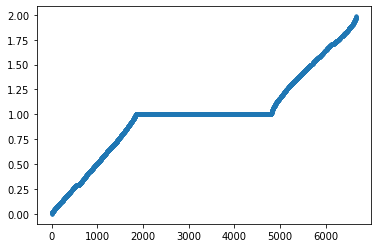

In [62]:
# plot eigenvalues
plt.scatter(range(eigenvalues.shape[0]), eigenvalues, marker='.')
plt.show()

In [63]:
# we select the number of eigenvectors heuristically, choosing the value K that maximizes the eigen-gap
k, M = 0, 0
for i in range(eigenvalues.shape[0]-1):
  gap = eigenvalues[i+1]-eigenvalues[i]
  if gap>=M:
    M = gap
    k = i

print(k)

4814


In [64]:
# list of point in R^k that we'll cluster using X-means algorithm
points = [tuple(eigenvectors[i, 1:k].real) for i in range(eigenvectors.shape[0])]

# to test the correctness of the algorithm let's generate random points according to 40 different Normal distributions
# we expect the xmeans to find 40 different clusters
#points = [tuple(np.random.normal(loc=i%40*100, size=4)) for i in range(500)]

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
# initialize the centers using K-means++
initial_centers = kmeans_plusplus_initializer(points, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 1000.
xmeans_instance = xmeans(points, initial_centers = initial_centers, kmax = 1000, tolerance = 0.025)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

In [65]:
# number of found clusters
len(clusters)

4

In [66]:
# let's build a dictionary {node : cluster index} assigning each node to its cluster
spectral_clusters = {}

# let's also build the partitioning we'll use to compute modularity
partitions = [] # list of lists

for i in range(len(clusters)):
  comm = []
  for node_index in clusters[i]:
    spectral_clusters[list(g.nodes())[node_index]] = i
    comm.append(list(g.nodes())[node_index])  
  partitions.append(comm)  

# compute modularity
modularity = nx_cd.modularity(g, communities=partitions, weight='Weight')
print(modularity)

0.001485978104264378


# Save nodes' statistics on Drive

In [67]:
authority_shifting = pd.read_csv(drive_path+'authority_shifting.csv')
consensus_clustering = pd.read_csv(drive_path+'consensus_clustering.csv')

# convert the dataframe into a dictonary {node : community index}
authority_shifting.set_index(authority_shifting.iloc[:, 0], inplace=True, drop=True)
authority_shifting = authority_shifting.iloc[:, 1]
authority_shifting = dict(authority_shifting)

# convert the dataframe into a dictonary {node : community index}
consensus_clustering.set_index(consensus_clustering.iloc[:, 0], inplace=True, drop=True)
consensus_clustering = consensus_clustering.iloc[:, 1]
consensus_clustering = dict(consensus_clustering)

# compute degree centrality
degree_centrality = nx.degree_centrality(g)

# save everything into a proper dictionary
# from this dictionary we then create the dataframe to save on drive
nodes_statistics = {}
for node in nodes:
  nodes_statistics[node] = [degree_centrality[node], clustering_coeffs[node], pagerank_centrality[node], 
                            hub_centrality[node], authority_centrality[node], louvain_communities[node], 
                            consensus_clustering[node], authority_shifting[node], spectral_clusters[node]]

nodes_statistics_df = pd.DataFrame.from_dict(nodes_statistics, orient='index', columns=['degree_centrality', 'clustering_coeffs', 'pagerank_centrality',
                                                                                     'hub_centrality', 'authority_centrality', 'louvain_communities',
                                                                                     'consensus_clustering', 'authority_shifting', 'spectral_clusters'])

# save the dataframe on google drive to access it later and use it in Gephi
nodes_statistics_df.to_csv(path_or_buf='/content/drive/MyDrive/Network_Science/nodes_statistics.csv')

# Robustness

In [68]:
# equation to solve numerically to determine critical threshold in case of targeted attacks
def function_to_optimize(x):
  gamma = gamma_CCDF
  return 2+(2-gamma)/(3-gamma)*kmin*(np.power(x, (3-gamma)/(1-gamma))-1)-np.power(x, (2-gamma)/(1-gamma))

# critical robustness threshold under random removal
fc_random_theoretical = 1 - 1/(k_theoretical-1)
# critical robustness threshold under targeted removal
fc_targeted_theoretical = sp.optimize.fsolve(function_to_optimize, x0=0.3)[0]
 
print('theoretical critical thresholds for network robustness')
print('fc_random = ', fc_random_theoretical)
print('fc_targeted = ', fc_targeted_theoretical)

# get size of Giant Component
largest_cc = max(nx.connected_components(g), key=len)
GC = g.subgraph(largest_cc)
GC_size = len(GC.nodes)

theoretical critical thresholds for network robustness
fc_random =  0.9699979797627057
fc_targeted =  0.20258766108824292


## Random node removal

In [69]:
# temporary graph from which we'll randomly remove nodes
graph = g.copy()

# number of removed nodes
f = 0

# dictionary in which we'll save {fraction of removed nodes : relative size of Giant Component}
robustness_random_removal = {}
robustness_random_removal[f/len(nodes)] = GC_size/GC_size

while f<len(nodes)-1:
  # number of removed nodes
  f+=1  
  # randomly select a node
  node_to_remove = np.random.choice(graph.nodes())
  # remove the node
  graph.remove_node(node_to_remove)
  
  # get relative size of Giant Component
  GC_fraction = len(max(nx.connected_components(graph), key=len))/GC_size
  
  # compute the empirical critical threshold using Molloy-Reed criterion
  graph_degrees = np.array(list(dict(graph.degree()).values()))
  inhomo_ratio_empirical = np.mean(np.power(graph_degrees, 2))/np.mean(graph_degrees)
  if inhomo_ratio_empirical <= 2:    
    fc_random_empirical = f/len(nodes)
  
  # store size against number of removed nodes
  robustness_random_removal[f/len(nodes)] = GC_fraction

<ipython-input-69-339824f4c941>:24: RuntimeWarning: invalid value encountered in double_scalars
  inhomo_ratio_empirical = np.mean(np.power(graph_degrees, 2))/np.mean(graph_degrees)


## Targeted node removal

In [70]:
# temporary graph from which we'll remove targeted nodes
graph = g.copy()

# number of removed nodes
f = 0

# dictionary in which we'll save {fraction of removed nodes : relative size of Giant Component}
robustness_targeted_removal = {}
robustness_targeted_removal[f/len(nodes)] = GC_size/GC_size

while f<len(nodes)-1:
  # number of removed nodes
  f+=1  
  # select the node with highest degree
  d = nx.degree_centrality(graph)
  node_to_remove = max(d, key=d.get)  
  # remove the node
  graph.remove_node(node_to_remove)

  # get relative size of Giant Component
  GC_fraction = len(max(nx.connected_components(graph), key=len))/GC_size

  # compute the empirical critical threshold using Molloy-Reed criterion
  graph_degrees = np.array(list(dict(graph.degree()).values()))
  inhomo_ratio_empirical = np.mean(np.power(graph_degrees, 2))/np.mean(graph_degrees)
  if inhomo_ratio_empirical <= 2:
    fc_targeted_empirical = f/len(nodes)
    
  # store size against number of removed nodes
  robustness_targeted_removal[f/len(nodes)] = GC_fraction

<ipython-input-70-b16366198ee1>:25: RuntimeWarning: invalid value encountered in double_scalars
  inhomo_ratio_empirical = np.mean(np.power(graph_degrees, 2))/np.mean(graph_degrees)


## Semi-targeted node removal

In [71]:
# temporary graph from which we'll randomly remove nodes
# graph = g.copy()

# # number of removed nodes
# f = 0
# robustness_semitargeted_removal = {}
# robustness_semitargeted_removal[f/len(nodes)] = GC_size/GC_size

# while f<len(nodes)-1:
#   # number of removed nodes
#   f+=1  
#   # randomly select a node based on its degree: higher degree nodes will be more likely to be removed
#   graph_degrees = np.array(list(dict(graph.degree()).values()))
#   node_to_remove = np.random.choice(graph.nodes(), p = graph_degrees/np.sum(graph_degrees))
#   # remove the node
#   graph.remove_node(node_to_remove)
  
#   # get size of Giant Component
#   GC_fraction = len(max(nx.connected_components(graph), key=len))/GC_size
  
#   # compute the empirical critical threshold using Molloy-Reed criterion
#   inhomo_ratio_empirical = np.mean(np.power(graph_degrees, 2))/np.mean(graph_degrees)
#   if inhomo_ratio_empirical <= 2:    
#     fc_semitargeted_empirical = f/len(nodes)
  
#   # store size against number of removed nodes
#   robustness_semitargeted_removal[f/len(nodes)] = GC_fraction

## Comparison

In [72]:
print(fc_random_empirical)
print(fc_targeted_empirical)
# print(fc_semitargeted_empirical)

0.9936993699369937
0.2812781278127813


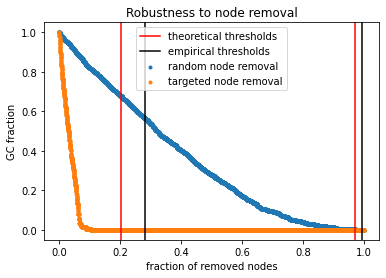

In [73]:
plt.scatter(list(robustness_random_removal.keys()), list(robustness_random_removal.values()), label='random node removal', marker='.')
plt.scatter(list(robustness_targeted_removal.keys()), list(robustness_targeted_removal.values()), label='targeted node removal', marker='.')
# plt.scatter(list(robustness_semitargeted_removal.keys()), list(robustness_semitargeted_removal.values()), label='targeted node removal', marker='.')

plt.axvline(x=fc_random_theoretical, c='r', label='theoretical thresholds')
plt.axvline(x=fc_targeted_theoretical, c='r')

plt.axvline(x=fc_random_empirical, c='k', label='empirical thresholds')
plt.axvline(x=fc_targeted_empirical, c='k')
# plt.axvline(x=fc_semitargeted_empirical, c='k')

plt.xlabel('fraction of removed nodes')
plt.ylabel('GC fraction')
plt.title('Robustness to node removal')
plt.legend()
plt.show()

# Link Prediction

## Splitting the network into Training and Test data

In [27]:
np.random.seed(12345)

edges = np.array(g.edges)
G = g.copy()

# we want the degree 1 nodes to remain in the training graph
# to do this we define a probability distribution which assigns zero probability
# to an edge connecting at least a degree 1 node, and uniform probability to all the other edges
p = np.ones(len(edges))
for i in range(len(edges)):
  if g.degree(edges[i][0])==1 or g.degree(edges[i][1])==1:
    p[i] = 0
# normalize via the sum to get a probability distribution
p = p/np.sum(p)

# Train-Val and Test splitting
edges_to_remove = np.random.choice(len(edges), size=int(20/100*len(edges)), replace=False, p=p)
Test_edges = [tuple(edges[i]) for i in edges_to_remove] # list of edges to remove
G.remove_edges_from(Test_edges) # remove the edges
Train_val_graph = G.copy() # Train-Validation Graph
edges = np.array(G.edges)

# redefine once again the custom probability ditribution 
# to avoid removing edges connecting to at least a degree 1 node
p = np.ones(len(edges))
for i in range(len(edges)):
  if g.degree(edges[i][0])==1 or g.degree(edges[i][1])==1:
    p[i] = 0
p = p/np.sum(p)

# Training and Validation splitting
edges_to_remove = np.random.choice(len(edges), size=int(20/100*len(edges)), replace=False, p=p)
Validation_edges = [tuple(edges[i]) for i in edges_to_remove] # list of edges to remove
G.remove_edges_from(Validation_edges) # remove the edges
Train_graph = G # Training Graph
Train_nodes = list(Train_graph.nodes())

# number of thresholds we'll check during the Validation phase
num_thresholds = 100

In [28]:
# custom function to choose the best threshold using the Train-Validation splitting
# from_matrix is used to detect whether the given 'matrix' argument is a numpy matrix or a generator object
# infact, networkx returns a generator for Jaccard Common Neighbours, Resource Allocation, Adamic Adar
# on the other hand though Local Path and Random Walk with Restart are built using a matrix

def prediction(matrix, Training_edges, Validation_edges, thresholds=[], num_thresholds=100, from_matrix=False):
  
  data = [] # here we'll save the edges and the related similarity coefficient
  scores = set() # here we'll save only the similarity coefficients
  if from_matrix==False: # in case 'matrix' is actually a generator object
    for u, v, p in matrix:
      if p>0:
        if (u, v) in Training_edges:
          flag = 0
        elif (u, v) in Validation_edges:
          flag = 1
        else:
          flag = 2
        data.append((u, v, p, flag)) # we need the flag to compute various metrics such as TP, FP, TN, FN
        scores.add(p)
  else: # if 'matrix' is an actual matrix
    for i in range(matrix.shape[0]):
      for j in range(matrix.shape[1]):
        if matrix[i,j]>0: # M[i,j] is the similarity coeff of vi and vj
          if (Train_nodes[i], Train_nodes[j]) in Training_edges:
            flag = 0
          elif (Train_nodes[i], Train_nodes[j]) in Validation_edges:
            flag = 1
          else:
            flag = 2
          data.append((Train_nodes[i], Train_nodes[j], matrix[i,j], flag))
          scores.add(matrix[i,j])
      
  # compute thresholds if not given
  a = min(scores)
  b = max(scores)
  if thresholds==[]:
    # define a number of num_thresholds equally spaced values between the minimum and maximum similarity coefficient
    thresholds = [a + k*(b-a)/num_thresholds for k in range(1, num_thresholds)]

  # compute predictions, TP, FP, TN, FN for each threshold
  predicted = {}
  TP = {} # True Positive
  FP = {} # False Positive
  TN = {} # True Negative
  FN = {} # False Negative
  for alpha in thresholds:
    predicted[alpha] = []
    TP[alpha] = 0
    FP[alpha] = 0
    TN[alpha] = 0
    FN[alpha] = 0  
    for u, v, p, flag in data:
      if flag != 0: # if the edge is not already present in the training graph
        if p >= alpha: # if the similarity coeff is greater than the threshold
          predicted[alpha].append((u, v)) # then the link is predicted (activated)
          if flag==1: # if the edge is in the validation set (so we wanted to predict it)
            TP[alpha] += 1
          elif flag==2: # if the edge is not in the training nor in the validation set (so we don't want to predict it)
            FP[alpha] += 1
        else: # if the similarity coeff is below the threshold (link not activated)
          if flag == 1: # if the edge is in the validation set (so we wanted to activate it)
            FN[alpha] += 1
          else: # if the edge is not in the training nor in the validation set (so we don't want to predict it)
            TN[alpha] += 1            
 
  # compute some metrics for each threshold
  precision = {}
  recall = {} # Recall or True Positive Rate
  F1_score = {}  
  FPR = {} # False Positive Rate
  optimal_score = np.Inf # needed to select the best threshold

  for alpha in thresholds:
    # compute some metrics
    if (TP[alpha]+FP[alpha])!=0:
      precision[alpha] = (TP[alpha]/(TP[alpha]+FP[alpha]))
    else:
      precision[alpha] = 0

    if (TP[alpha]+FN[alpha])!=0:
      recall[alpha] = (TP[alpha]/(TP[alpha]+FN[alpha]))
    else:
      recall[alpha] = 0

    if (precision[alpha]+recall[alpha])!=0:
      F1_score[alpha] = (2*(precision[alpha]*recall[alpha])/(precision[alpha]+recall[alpha]))
    else:
      F1_score[alpha] = 0

    if (FP[alpha]+TN[alpha])!=0:
      FPR[alpha] = (FP[alpha]/(FP[alpha]+TN[alpha]))
    else:
      FPR[alpha] = 0
      
    # choose the best alpha as the one minimizing FPR^2 + (1 - TPR)^2
    if np.power(FPR[alpha], 2) + np.power(1 - recall[alpha], 2) <= optimal_score:
      optimal_score = np.power(FPR[alpha], 2) + np.power(1 - recall[alpha], 2)
      best_alpha = alpha
  
  # finally return the obtained results
  return (predicted, thresholds, best_alpha, F1_score, precision, recall, FPR)

## Common Neighbours Approach

In [29]:
# Jaccard Common Neighbours
JCN = nx.jaccard_coefficient(Train_graph)
JCN_results = prediction(JCN, set(Train_graph.edges()), set(Validation_edges), num_thresholds=num_thresholds+1)

# Resource Allocation
RA = nx.resource_allocation_index(Train_graph)
RA_results = prediction(RA, set(Train_graph.edges()), set(Validation_edges), num_thresholds=num_thresholds+1)

# Adamic Adar
AA = nx.adamic_adar_index(Train_graph)
AA_results = prediction(AA, set(Train_graph.edges()), set(Validation_edges), num_thresholds=num_thresholds+1)

In [30]:
print('\t F1_score \t\t precision \t\t recall \t\t FPR')
print('JCN: \t', JCN_results[3][JCN_results[2]], '\t', JCN_results[4][JCN_results[2]], '\t', JCN_results[5][JCN_results[2]], '\t', JCN_results[6][JCN_results[2]])
print('RA: \t', RA_results[3][RA_results[2]], '\t', RA_results[4][RA_results[2]], '\t', RA_results[5][RA_results[2]], '\t', RA_results[6][RA_results[2]])
print('AA: \t', AA_results[3][AA_results[2]], '\t', AA_results[4][AA_results[2]], '\t', AA_results[5][AA_results[2]], '\t', AA_results[6][AA_results[2]])

	 F1_score 		 precision 		 recall 		 FPR
JCN: 	 0.0053904402192845756 	 0.0027145811789038264 	 0.37789203084832906 	 0.5983668313869746
RA: 	 0.024129970817544314 	 0.012272928666371289 	 0.712082262210797 	 0.24700290291843022
AA: 	 0.027531661410622216 	 0.014039207678170308 	 0.7069408740359897 	 0.21398497573514746


## Path based techniques

In [31]:
# Katz Local Paths
A = nx.adjacency_matrix(Train_graph)
beta = 1
LP =  sp.sparse.csr_matrix.dot(A, A) # A^2
LP = LP + beta*sp.sparse.csr_matrix.dot(LP, A) # A^2 + beta*A^3
LP_results = prediction(LP.toarray(), set(Train_graph.edges()), set(Validation_edges), num_thresholds=num_thresholds+1, from_matrix=True)

In [32]:
# Random Walk with Restart
# we use this matrix to save the local pagerank vectors
RWR = np.zeros((len(Train_nodes), len(Train_nodes)))
for i in range(len(Train_nodes)):  
  # local pagerank vector wrt node vi
  pi = nx.pagerank(Train_graph, alpha=0.85, personalization={Train_nodes[i] : 1}, weight='Weight')
  # save it as i-th row 
  RWR[i, :] = np.array(list(pi.values()))

# final matrix: RWR(i, j) = p_ij + p_ji where p_ij is the j-th component of the local pagerank wrt node vi
RWR = RWR + RWR.T

In [33]:
RWR_results = prediction(RWR, set(Train_graph.edges()), set(Validation_edges), num_thresholds=num_thresholds+1, from_matrix=True)

In [34]:
print('\t F1_score \t\t precision \t\t recall \t\t FPR')
print('LP: \t', LP_results[3][LP_results[2]], '\t', LP_results[4][LP_results[2]], '\t', LP_results[5][LP_results[2]], '\t', LP_results[6][LP_results[2]])
print('RWR: \t', RWR_results[3][RWR_results[2]], '\t', RWR_results[4][RWR_results[2]], '\t', RWR_results[5][RWR_results[2]], '\t', RWR_results[6][RWR_results[2]])

	 F1_score 		 precision 		 recall 		 FPR
LP: 	 0.024976895187089742 	 0.012846138845553821 	 0.44851063829787235 	 0.03104674376029218
RWR: 	 0.01536628198695434 	 0.007927519818799546 	 0.24923702950152593 	 0.0013826277557516368


## Comparison with ROC

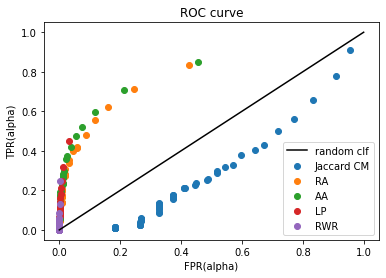

In [35]:
# plot ROC curve for previous models
plt.scatter(list(JCN_results[6].values()), list(JCN_results[5].values()), label='Jaccard CM')
plt.scatter(list(RA_results[6].values()), list(RA_results[5].values()), label='RA')
plt.scatter(list(AA_results[6].values()), list(AA_results[5].values()), label='AA')
plt.scatter(list(LP_results[6].values()), list(LP_results[5].values()), label='LP')
plt.scatter(list(RWR_results[6].values()), list(RWR_results[5].values()), label='RWR')

# let's also plot a random classifier for comparison
plt.plot(range(2), range(2), label='random clf', c='k') 

plt.xlabel('FPR(alpha)')
plt.ylabel('TPR(alpha)')
plt.title('ROC curve')

plt.legend()
plt.show()

## Predictions on Test set

In [36]:
# Resource Allocation
RA = nx.resource_allocation_index(Train_val_graph)
RA_results_test = prediction(RA, set(Train_val_graph.edges()), set(Test_edges), thresholds=[RA_results[2]])

# Adamic Adar
AA = nx.resource_allocation_index(Train_val_graph)
AA_results_test = prediction(AA, set(Train_val_graph.edges()), set(Test_edges), thresholds=[AA_results[2]])

# Local Path
A = nx.adjacency_matrix(Train_val_graph)
beta = 1
LP =  sp.sparse.csr_matrix.dot(A, A)
LP = LP + beta*sp.sparse.csr_matrix.dot(LP, A)
LP_results_test = prediction(LP.toarray(), set(Train_val_graph.edges()), set(Test_edges), thresholds=[LP_results[2]], from_matrix=True)

In [37]:
print('\t F1_score \t\t precision \t\t recall \t\t FPR')
print('RA: \t', RA_results_test[3][RA_results_test[2]], '\t', RA_results_test[4][RA_results_test[2]],
      '\t', RA_results_test[5][RA_results_test[2]], '\t', RA_results_test[6][RA_results_test[2]])

print('AA: \t', AA_results_test[3][AA_results_test[2]], '\t', AA_results_test[4][AA_results_test[2]],
      '\t', AA_results_test[5][AA_results_test[2]], '\t', AA_results_test[6][AA_results_test[2]])

print('LP: \t', LP_results_test[3][LP_results_test[2]], '\t', LP_results_test[4][LP_results_test[2]],
      '\t', LP_results_test[5][LP_results_test[2]], '\t', LP_results_test[6][LP_results_test[2]])

	 F1_score 		 precision 		 recall 		 FPR
RA: 	 0.03531883077580375 	 0.01811210516706226 	 0.7065527065527065 	 0.1862996424909237
AA: 	 0.19641888225718937 	 0.1586327782646801 	 0.25783475783475784 	 0.006651331652024499
LP: 	 0.015224849081190331 	 0.007709087971129634 	 0.6071049840933191 	 0.06117280140723883
